# Outcome Prediction (Node Classification) with TransE Model + MLP

In [1]:
import os
import joblib

import numpy as np
import pandas as pd

from pykeen.triples import TriplesFactory
from pykeen.predict import predict_target
from pykeen.pipeline import pipeline

## 1. Load KG and remove outcomes

In [2]:
num_patients = 1000
df = pd.read_csv(f"../Data Generation/sphn_transductive_{num_patients}_0.nt", sep=" ", header=None)
df.drop(columns=df.columns[-1], axis=1, inplace=True)
df.columns=['s', 'r', 'd']
df

,s,r,d
0,<http://nvasc.org/7d69a2a1-8681-4e71-9ca2-fa75...,<http://www.w3.org/2000/01/rdf-schema#label>,entry_code^^<http://www.w3.org/2001/XMLSchema#...
1,<http://nvasc.org/f5856cd3-2d82-4d7b-b8ab-18cd...,<http://www.w3.org/1999/02/22-rdf-syntax-ns#type>,<http://sphn.org/Diagnosis>
2,<http://nvasc.org/db9d32b8-a429-4ab6-8ddf-3753...,<http://sphn.org/hasSubjectPseudoIdentifier>,<http://nvasc.org/synth_patient_769>
3,<http://nvasc.org/6982d639-68e1-4d97-bbdc-32b7...,<http://sphn.org/hasSubjectPseudoIdentifier>,<http://nvasc.org/synth_patient_397>
4,<http://nvasc.org/a24f2ca8-60bb-485a-9428-1e88...,<http://www.w3.org/2000/01/rdf-schema#label>,iot^^<http://www.w3.org/2001/XMLSchema#string>
...,...,...,...
111930,<http://nvasc.org/synth_patient_138>,<http://nvasc.org/hasOutcome>,<http://nvasc.org/outcome_0.0>
111931,_:na4af9ca095e94f96acb25b3c689a54b5b1,<http://sphn.org/hasValue>,5
111932,_:n857dfe592f82471cafdeebc283906835b1,<http://www.w3.org/1999/02/22-rdf-syntax-ns#type>,<http://sphn.org/Quantity>
111933,<http://nvasc.org/c656d49c-08c6-49cd-90b0-7778...,<http://www.w3.org/2000/01/rdf-schema#label>,ica_therapy^^<http://www.w3.org/2001/XMLSchema...


### Remove outcomes from KG

In [4]:
outcome = df['d'].str.contains('outcome_0.0|outcome_1.0|outcome_2.0')
node_df = df[~outcome]
node_df = node_df.reset_index(drop=True)
outcome = node_df['s'].str.contains('outcome_0.0|outcome_1.0|outcome_2.0')
node_df = node_df[~outcome]
node_df = node_df.reset_index(drop=True)

In [5]:
ent_to_id = {k: v for v, k in enumerate(set(node_df['s']).union(set(node_df['d'])), start=0)}
rel_to_id = {k: v for v, k in enumerate(set(node_df['r']), start=0)}

patients = [f"<http://nvasc.org/synth_patient_{i}>" for i in range(num_patients)]
patient_id = []
for patient in patients:
    patient_id.append(ent_to_id[patient])

num_nodes = max(ent_to_id.values()) + 1
num_rels = max(rel_to_id.values()) + 1

events = node_df.copy()
events["s"] = node_df.s.map(ent_to_id)
events["d"] = node_df.d.map(ent_to_id)
events["r"] = node_df.r.map(rel_to_id)

ent_to_id = pd.DataFrame.from_dict(ent_to_id, orient='index')
rel_to_id = pd.DataFrame.from_dict(rel_to_id, orient='index')

### Save events, entities and relations to 'processed_data' folder

In [6]:
path = 'processed_data'
if not os.path.exists(path):
    os.makedirs(path)

events.to_csv(f'{path}/sphn_events_{num_patients}_noOutcome.tsv', sep='\t', index=False, header=None)
ent_to_id.to_csv(f'{path}/sphn_entities_{num_patients}_noOutcome.tsv', sep='\t', header=None)
rel_to_id.to_csv(f'{path}/sphn_relations_{num_patients}_noOutcome.tsv', sep='\t', header=None)

## 2. Training the model

In [3]:
path = 'processed_data'
tf = TriplesFactory.from_path(f'{path}/sphn_events_{num_patients}_noOutcome.tsv', create_inverse_triples=True)
print(tf)

TriplesFactory(num_entities=33563, num_relations=20, create_inverse_triples=True, num_triples=110935, path="/home/baical77/projects/neurovasc/notebooks/Graphs/processed_data/sphn_events_1000_noOutcome.tsv")


INFO:pykeen.pipeline.api:Using device: gpu
INFO:pykeen.triples.triples_factory:Creating inverse triples.


Training epochs on cuda:0:   0%|          | 0/10 [00:00<?, ?epoch/s]

INFO:pykeen.triples.triples_factory:Creating inverse triples.


Evaluating on cuda:0:   0%|          | 0.00/111k [00:00<?, ?triple/s]

INFO:pykeen.evaluation.evaluator:Evaluation took 209.72s seconds


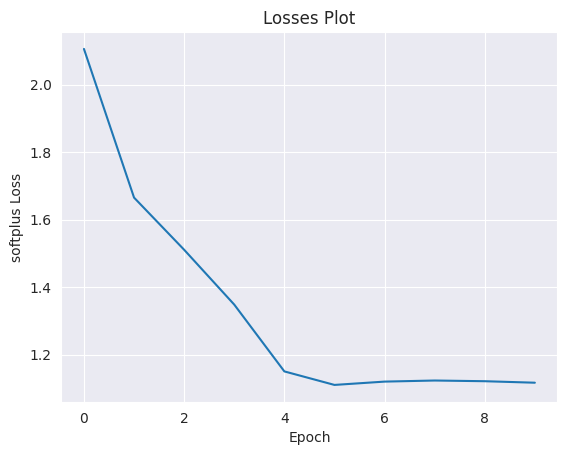

In [9]:
model_name = 'TransE'
embedding_dim = 32
epochs = 10

result = pipeline(
    training=tf,
    testing=tf,
    model=model_name,
    model_kwargs=dict(
        embedding_dim=embedding_dim,
        loss="softplus",
    ),
    training_kwargs=dict(
        num_epochs=epochs,
        # label_smoothing=0.1,
        use_tqdm_batch=False,
    ),
    optimizer_kwargs=dict(
        lr=0.01,
        weight_decay=1e-5,
    ),
    training_loop='sLCWA',
    negative_sampler='basic',
    device='gpu',
    use_tqdm=True,
)

#plot loss
loss_plot = result.plot_losses()

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F


entity = pd.read_csv(f'processed_data/sphn_entities_{num_patients}_noOutcome.tsv', sep='\t', index_col=0, header=None)
entity = entity.to_dict()[1]
patient_id = []
for i in range(num_patients):
    idx = f'<http://nvasc.org/synth_patient_{i}>'
    patient_id.append(entity[idx])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = result.model
entity_embedding = model.entity_representations[0](indices=None).detach().cpu()
patient_embedding = entity_embedding[patient_id]
print(f'Patient embedding size: {patient_embedding.shape}')

patient_embedding = patient_embedding.to(device)
y = joblib.load('../Data Generation/outcomes_10_0.joblib')
y = torch.Tensor(y).long().to(device)

train_x, train_y = patient_embedding[:int(num_patients*0.8)], y[:int(num_patients*0.8)]
val_x, val_y = patient_embedding[int(num_patients*0.8):int(num_patients*0.9)], y[int(num_patients*0.8):int(num_patients*0.9)]
test_x, test_y = patient_embedding[int(num_patients*0.9):], y[int(num_patients*0.9):]

Patient embedding size: torch.Size([1000, 32])


In [17]:
# MLP classifier
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(32, 32),
            nn.ReLU(),
            nn.Dropout(p=0.2),
            nn.Linear(32, 32),
            nn.ReLU(),
            # nn.Dropout(p=0.2),
            nn.Linear(32, 3),
        )

    def forward(self, x):
        x = self.linear_relu_stack(x)
        return F.log_softmax(x, dim=1)
    
model = NeuralNetwork().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-5)


def train():
    model.train()
    optimizer.zero_grad()
    out = model(train_x)
    loss = F.nll_loss(out, train_y)
    loss.backward()
    optimizer.step()
    return float(loss)

@torch.no_grad()
def test():
    model.eval()
    pred = model(patient_embedding).argmax(dim=-1)
    train_acc = float((pred[:int(num_patients*0.8)] == train_y).float().mean())
    val_acc = float((pred[int(num_patients*0.8):int(num_patients*0.9)] == val_y).float().mean())
    test_acc = float((pred[int(num_patients*0.9):] == test_y).float().mean())
    return train_acc, val_acc, test_acc

import time

times = []
best_acc = float(0.)

for epoch in range(1, 1001):
    start = time.time()
    loss = train()
    train_acc, val_acc, test_acc = test()
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, | Train: {train_acc:.4f}, Val: {val_acc:.4f} '
        f'Test: {test_acc:.4f}')
    # # Early stopping
    # if val_acc >= best_acc:
    #     best_acc = val_acc
    #     patience = 50  # Reset patience counter
    # else:
    #     patience -= 1
    #     if patience == 0:
    #         print("Early stopping...")
    #         break
    times.append(time.time() - start)
print(f"Median time per epoch: {torch.tensor(times).median():.4f}s")

Epoch: 01, Loss: 1.1199, | Train: 0.4338, Val: 0.4500 Test: 0.3700
Epoch: 02, Loss: 1.0861, | Train: 0.4338, Val: 0.4500 Test: 0.3700
Epoch: 03, Loss: 1.0595, | Train: 0.4338, Val: 0.4500 Test: 0.3700
Epoch: 04, Loss: 1.0360, | Train: 0.4338, Val: 0.4500 Test: 0.3700
Epoch: 05, Loss: 1.0148, | Train: 0.4338, Val: 0.4500 Test: 0.3700
Epoch: 06, Loss: 0.9994, | Train: 0.4338, Val: 0.4500 Test: 0.3700
Epoch: 07, Loss: 0.9861, | Train: 0.4338, Val: 0.4500 Test: 0.3700
Epoch: 08, Loss: 0.9791, | Train: 0.4338, Val: 0.4500 Test: 0.3700
Epoch: 09, Loss: 0.9800, | Train: 0.4650, Val: 0.4900 Test: 0.4800
Epoch: 10, Loss: 0.9828, | Train: 0.4525, Val: 0.4500 Test: 0.4900
Epoch: 11, Loss: 0.9858, | Train: 0.4512, Val: 0.4500 Test: 0.5000
Epoch: 12, Loss: 0.9867, | Train: 0.4512, Val: 0.4500 Test: 0.5000
Epoch: 13, Loss: 0.9821, | Train: 0.4512, Val: 0.4500 Test: 0.5000
Epoch: 14, Loss: 0.9784, | Train: 0.4575, Val: 0.4600 Test: 0.5000
Epoch: 15, Loss: 0.9721, | Train: 0.4612, Val: 0.5000 Test: 0.

In [18]:
from sklearn.metrics import roc_auc_score

model.eval()
with torch.no_grad():
    out = model(patient_embedding).cpu()
    prob = F.softmax(out, dim=1)
auc = roc_auc_score(test_y.cpu(), prob[int(num_patients*0.9):], multi_class='ovr')
print(f'ROC AUC score: {auc:.4f}')

ROC AUC score: 0.5825
